In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as skpp
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
np.random.seed(42)

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
downloaded = drive.CreateFile({'id':"1JJKTmOX7NnWHzx4HqXcSq9OKslrVBVuT"})
downloaded.GetContentFile('lyrics.csv')

In [5]:
def formatdata(path):
    data = pd.read_csv(path)
    data = data[data['lyrics'].notnull()]
    
    # Remove punctuation
    data['lyrics'] = data['lyrics'].str.replace("[-\?.,\/#!$%\^&\*;:{}=\_~()]", ' ')
    
    # Remove song identifiers using regex
    data['lyrics'] = data['lyrics'].str.replace("\[(.*?)\]", ' ')
    data['lyrics'] = data['lyrics'].str.replace("' | '", ' ')
    data['lyrics'] = data['lyrics'].str.replace('x[0-9]+', ' ')
    
    # Remove lyricless songs 
    data = data[data['lyrics'].str.strip().str.lower() != 'instrumental']
    
    # fix shit like [verse] and 'repeat x2'
    data = data[~data['lyrics'].str.contains(r'[^\x00-\x7F]+')]
    data = data[data['lyrics'].str.strip() != '']
    data = data[data['genre'].str.lower() != 'not available']
    
    # Grouping Folk and Country to one genre
    data['genre'] = np.where(data['genre'] == "Folk", "Country", data["genre"])
    #data = data[data.genre != "Other"]
    data = data[data['genre'].isin(['Rock', 'Pop', 'Hip-Hop', 'Country'])]
    
    return data.copy()

In [6]:
data = formatdata("lyrics.csv")[['lyrics', 'genre']]

In [7]:
lyrics = data['lyrics'].values 

label_encoder = skpp.LabelEncoder()
indexed_labels = np.array(label_encoder.fit_transform(data['genre'].values))

Text(0.5, 1.0, 'Genre Distribution')

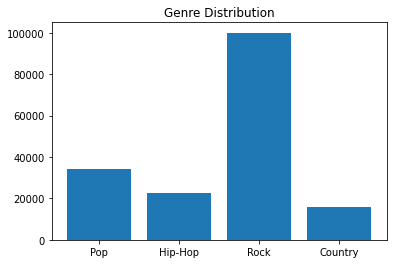

In [8]:
import matplotlib.pyplot as plt
from collections import Counter
ct = Counter(data['genre'])
plt.bar(ct.keys(), ct.values())
plt.title("Genre Distribution")

In [ ]:
label_encoder.classes_ # 0 -> Country, 1 ->  Hip-Hop, 2 -> POP, 3 -> Rock"

array(['Country', 'Hip-Hop', 'Pop', 'Rock'], dtype=object)

In [9]:
# Test Train Split
X_train, X_temp, y_train, y_temp = train_test_split(lyrics, indexed_labels, train_size=0.8)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, train_size=0.6)

In [11]:
#### Fit BoW
cv = CountVectorizer(strip_accents='ascii', lowercase=True, stop_words='english', analyzer='word') #create the CountVectorizer object
cv.fit(lyrics) #fit into our dataset

#Creating bag of words representations
bow = cv.transform(X_train) 
print(bow.shape[0], 'samples x ',bow.shape[1],'words in vocabulary')

138145 samples x  156253 words in vocabulary


In [ ]:
models = {'Logistic Regression':LogisticRegression(max_iter=500)}
for the_model in models.keys():
    print ("Training", the_model)
    models[the_model].fit(bow, y_train)

Training Logistic Regression


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
y_pred = models['Logistic Regression'].predict(cv.transform(X_test))
y_true = y_test
perc = lambda x: round(x * 100, 2)
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Accuracy:", perc( accuracy_score(y_true, y_pred)))
print("F1:", perc(f1_score(y_true, y_pred, average='weighted')))

Confusion Matrix:
 [[ 662   26  157 1072]
 [  16 2011  238  364]
 [ 196  195 1573 2169]
 [ 567  251 1252 9973]]
Accuracy: 68.62
F1: 67.41


In [ ]:
tfidf = TfidfVectorizer()
tfidf.fit(lyrics) #fit into our dataset

#Creating bag of words representations
tfidf_vect = tfidf.transform(X_train) 
print(tfidf_vect.shape[0], 'samples x ',tfidf_vect.shape[1],'words in vocabulary')

138145 samples x  156253 words in vocabulary


In [ ]:
models = {'Logistic Regression':LogisticRegression(max_iter=500)}
for the_model in models.keys():
    print ("Training", the_model)
    models[the_model].fit(tfidf_vect, y_train)

Training Logistic Regression


In [ ]:
y_pred = models['Logistic Regression'].predict(tfidf.transform(X_test))
y_true = y_test
perc = lambda x: round(x * 100, 2)
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Accuracy:", perc( accuracy_score(y_true, y_pred)))
print("F1:", perc(f1_score(y_true, y_pred, average='weighted')))

Confusion Matrix:
 [[  536     3   138  1240]
 [   10  1956   182   481]
 [  101   141  1233  2658]
 [  282    87   636 11038]]
Accuracy: 71.24
F1: 70.56


In [ ]:
# Tune CountVecorizer + Logistic Reg

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

groups = np.repeat([-1,0], [100000, 10000])
split = PredefinedSplit(groups)

param_grid =  {'vectorizer__min_df': [1,5], 
              'vectorizer__max_df': [0.8, 1.0],
              'classifier__C': [1.0, 0.1], 
              'classifier__fit_intercept': [True, False]}

estimator = Pipeline([('vectorizer', CountVectorizer(lowercase=True, ngram_range=(1,1))),
                 ('classifier', LogisticRegression(penalty="l2", C=1, max_iter=200))])

tuner = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=10, cv = split)
tuner.fit(X_train, y_train)

Fitting 1 folds for each of 16 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.8min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 15.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_r

In [16]:
tuner.best_params_

{'classifier__C': 0.1,
 'classifier__fit_intercept': True,
 'vectorizer__max_df': 0.8,
 'vectorizer__min_df': 1}

In [17]:
tuner.best_score_

0.7092

In [18]:
param_grid =  {'vectorizer__min_df': [1,5], 
              'vectorizer__max_df': [0.8, 1.0],
              'classifier__C': [1.0, 0.1], 
              'classifier__fit_intercept': [True, False]}

estimator_tfidf = Pipeline([('vectorizer', TfidfVectorizer(lowercase=True, ngram_range=(1,1))),
                 ('classifier', LogisticRegression(penalty="l2", C=1, max_iter=200))])

tuner2 = GridSearchCV(estimator=estimator_tfidf, param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=10, cv = split)
tuner2.fit(X_train, y_train)

Fitting 1 folds for each of 16 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.0min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 11.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram

In [19]:
tuner2.best_score_

0.7184